# Villin: mindist and rmsdCA model

In [1]:
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import pyemma
import mdtraj as md
from glob import glob

## Define auxiliary functions

Here, we define a set of functions which will make plotting easier.

In [2]:
def plot_its(lags, model, bayesian_model, ax, ylabel, dt=2.0E-4, confidence_interval=0.98):
    cout = 50 * (1.0 - confidence_interval)
    ax.fill_between(
        lags * dt,
        0.0,
        lags * dt,
        alpha=0.5, facecolor='grey')
    ax.plot(lags * dt, lags * dt, linewidth=2, color='black')
    for i in range(model.shape[1]):
        ax.fill_between(
            lags * dt,
            np.percentile(bayesian_model[:, :, i], cout, axis=1),
            np.percentile(bayesian_model[:, :, i], 100 - cout, axis=1),
            alpha=0.3, facecolor='C%d' % i)
        ax.plot(lags * dt, model[:, i], color='C%d' % i)
        ax.plot(lags * dt, np.median(bayesian_model[:, :, i], axis=1), ':o', color='C%d' % i)
    ax.set_xlabel(r'lagtime / $\mu$s')
    ax.set_ylabel(ylabel)
    
def get_lagtime_from_array(lags, lagtime, dt=2.0E-4):
    idx = np.argmin(np.abs(lags * dt - lagtime))
    return idx, lags[idx]

def get_free_energy(tics, bins=100, use=[0, 1]):
    z, xedge, yedge = np.histogram2d(*tics[:, use].T, bins=bins)
    x = 0.5 * (xedge[:-1] + xedge[1:])
    y = 0.5 * (yedge[:-1] + yedge[1:])
    z = np.maximum(z, np.min(z[z > 0]))
    f = -np.log(z)
    f -= np.min(f)
    xx, yy = np.meshgrid(x, y)
    xy = np.array([xx.reshape(-1,), yy.reshape(-1,)]).T
    return dict(x=x, y=y, xx=xx, yy=yy, xy=xy, f=f.T, use=use)

def draw_free_energy(fe, ax, bw=False):
    if bw:
        cmap = mpl.cm.bone
        alpha=0.2
    else:
        cmap = mpl.cm.jet
        alpha=None
    levels = np.linspace(fe['f'].min(), fe['f'].max(), 100, endpoint=False)
    return ax.contourf(fe['x'], fe['y'], fe['f'], levels, cmap=cmap, alpha=alpha, vmin=0.0, vmax=np.max(fe['f']))

def get_metastable_distribution(model, state):
    pi = model.stationary_distribution.copy()
    for i, s in enumerate(model.metastable_sets):
        if i == state:
            continue
        pi[s] = 0.0
    pi /= pi.sum()
    return pi

def cca(traj_a, traj_b):
    def _isqrt(x):
        w, v = np.linalg.eigh(x)
        return np.dot(v, np.dot(np.diag(1.0 / np.sqrt(w)), v.T))
    return np.linalg.svd(
        np.dot(
            _isqrt(np.dot(traj_a.T, traj_a)),
            np.dot(
                np.dot(traj_a.T, traj_b),
                _isqrt(np.dot(traj_b.T, traj_b)))))

## Create a feature reader


In [3]:
path='/home/esuarez/Documents/DESHAWTRAJS/DESRES-Trajectory_2F4K-0-protein/2F4K-0-protein/'
trajs = '2F4K-0-protein-*.dcd'

traj_files = [f for f in sorted(glob(path + trajs))]
pdb_file = path + 'villin.pdb'

features = pyemma.coordinates.featurizer(pdb_file)
features.add_residue_mindist()
features.add_minrmsd_to_ref(path + '2F4K-0-protein-000.dcd', ref_frame=9000)
source = pyemma.coordinates.source([traj_files], features=features, chunk_size=10000)

14-09-17 13:14:55 pyemma.coordinates.data.featurization.featurizer.MDFeaturizer[0] WARNING  Using all residue pairs with schemes like closest or closest-heavy is very time consuming. Consider reducing the residue pairs


## RMSD

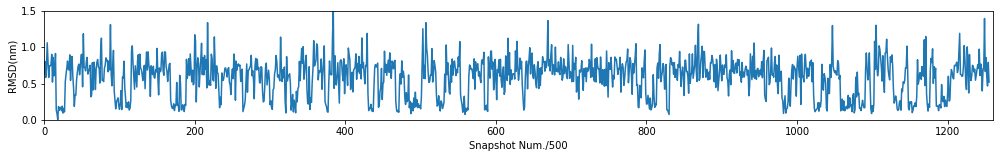

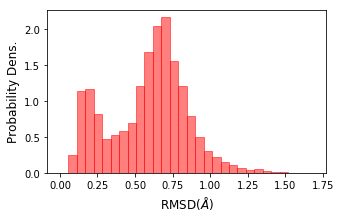

In [4]:
reference = md.load_dcd(path + '2F4K-0-protein-000.dcd', top=pdb_file)

CA_atoms = reference.topology.select('name CA and resid 1 to 33')

rmsd = []

for traj_name in traj_files:
    traj = md.load_dcd(traj_name, top=pdb_file)
    for element in md.rmsd(traj, reference,9000, atom_indices=CA_atoms):
        rmsd.append(element)

fig = plt.figure(figsize = (17, 2))
plt.plot(rmsd[::500])
plt.axis([0, 1260, 0.0, 1.5])
plt.ylabel("RMSD(nm)")
plt.xlabel("Snapshot Num./500")
plt.show()


#histogram
fig =plt.figure(figsize=(5, 3))

ax1 = fig.add_subplot(111)
ax1.hist(rmsd[::100], normed=True, bins=30, color="r", alpha=0.5, edgecolor="r")
ax1.set_xlabel("RMSD$(\AA)$", fontsize=12)
ax1.set_ylabel("Probability Dens.", fontsize=12)

# to Angstrom
rmsd = np.array(rmsd) * 10.0

## Discretization

We need to increase the transformation lagtime and number of cluster centers to get a good ITS convergence.

Widget Javascript not detected.  It may not be installed or enabled properly.


Widget Javascript not detected.  It may not be installed or enabled properly.


Widget Javascript not detected.  It may not be installed or enabled properly.


Widget Javascript not detected.  It may not be installed or enabled properly.


Widget Javascript not detected.  It may not be installed or enabled properly.


14-09-17 13:24:18 pyemma.coordinates.clustering.kmeans.KmeansClustering[3] INFO     Cluster centers converged after 2 steps.


Widget Javascript not detected.  It may not be installed or enabled properly.


Widget Javascript not detected.  It may not be installed or enabled properly.


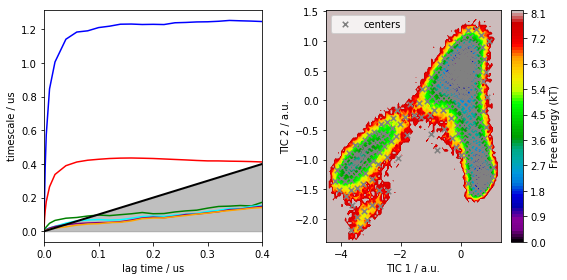

In [5]:
tica = pyemma.coordinates.tica(data=source, lag=500, dim=2).get_output()[0]
cluster = pyemma.coordinates.cluster_kmeans(tica, k=400, max_iter=50)

lags = np.asarray([1, 5, 10, 20, 50] + [i * 100 for i in range(1, 21)])
fig, axes = plt.subplots(1, 2, figsize=(8, 4))
pyemma.plots.plot_implied_timescales(
    pyemma.msm.its(cluster.dtrajs, lags=lags, errors=None, nits=6),
    ylog=False, ax=axes[0], units='us', dt=2.0E-4)
pyemma.plots.plot_free_energy(*tica.T, ax=axes[1], cmap=mpl.cm.nipy_spectral)
axes[1].scatter(*cluster.clustercenters.T, marker='x', c='grey', s=30, label='centers')
axes[1].legend()
axes[1].set_xlabel('TIC 1 / a.u.')
axes[1].set_ylabel('TIC 2 / a.u.')
fig.tight_layout()

## MSM estimation and analysis

At $\tau=0.15\mu s$, the ITS are reasonably flat and we can build an MSM which passes the CK test using two metastable states.

Widget Javascript not detected.  It may not be installed or enabled properly.


Widget Javascript not detected.  It may not be installed or enabled properly.


Widget Javascript not detected.  It may not be installed or enabled properly.


Widget Javascript not detected.  It may not be installed or enabled properly.


Widget Javascript not detected.  It may not be installed or enabled properly.


Widget Javascript not detected.  It may not be installed or enabled properly.


Widget Javascript not detected.  It may not be installed or enabled properly.


Widget Javascript not detected.  It may not be installed or enabled properly.


Widget Javascript not detected.  It may not be installed or enabled properly.


Widget Javascript not detected.  It may not be installed or enabled properly.


Widget Javascript not detected.  It may not be installed or enabled properly.


Estimated at lagtime 700 steps


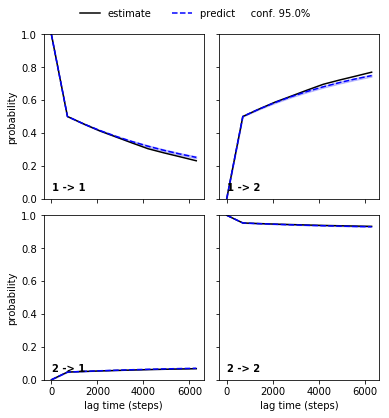

In [6]:
lag = get_lagtime_from_array(lags, 0.15, dt=2.0E-4)[1]
pyemma.plots.plot_cktest(pyemma.msm.bayesian_markov_model(cluster.dtrajs, lag=lag, dt_traj='0.0002 us').cktest(2))
print('Estimated at lagtime %d steps' % lag)

## Question

Do we actually need the RMSD feature?

In [7]:
# CCA for RMSD with TICA(mindist + RMSD)
print(cca(rmsd.reshape(-1, 1), tica)[1])

# CCA for RMSD with TICA(mindist)
features = pyemma.coordinates.featurizer(pdb_file)
features.add_residue_mindist()
source = pyemma.coordinates.source([traj_files], features=features, chunk_size=10000)
tica = pyemma.coordinates.tica(data=source, lag=500, dim=2).get_output()[0]
print(cca(rmsd.reshape(-1, 1), tica)[1])

[ 0.34339231]
14-09-17 13:32:40 pyemma.coordinates.data.featurization.featurizer.MDFeaturizer[4] WARNING  Using all residue pairs with schemes like closest or closest-heavy is very time consuming. Consider reducing the residue pairs


Widget Javascript not detected.  It may not be installed or enabled properly.


Widget Javascript not detected.  It may not be installed or enabled properly.


[ 0.3403109]


A canonical correlation analysis suggests that it does not play a big role in the twodimensional TICA projection next to the residue mindist feature.